In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import os
import sys

import fitsio
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
import healpy as hp
from healpy.newvisufunc import projview
#import pymaster as nmt

sys.path.insert(0, '/home/aew492/lss-dipoles')
#sys.path.insert(0, '/home/investigator/code/lss-dipoles')
#sys.path.insert(0, '..')
import tools
from qso_sample import QSOSample
import dipole
import ellisbaldwin
import multipoles
from jackknife import get_longitude_subsamples_from_hpmap, compute_jackknife_uncertainty, covar_jackknife

In [3]:
import matplotlib
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['legend.fontsize'] = 16

matplotlib.rc('text', usetex=True)

In [4]:
basedir = '../../quasar_data_abby/catalogs'

In [3]:
color_quaia = 'mediumvioletred'
color_catwise = 'teal'
lw = 2
lw_grid = 0.5

### functions

In [4]:
def C_1(dipole_amplitude):  # from the new Abghari et al. (including Douglas Scott), eq. 3.3
    # return dipole_amplitude**2 / 3
    return 4 * np.pi / 9 * dipole_amplitude**2

def D(C_1):
    return np.sqrt(C_1) * 9 / (4 * np.pi)

In [5]:
# define function for jackknife: output needs to be just the Cells, to compute the uncertainty
def Cells_for_jk(overdensity_map, Wmask, max_ell, selfunc=None):
    ells, Cells = multipoles.compute_Cells_in_overdensity_map(overdensity_map, Wmask, max_ell, selfunc=selfunc)
    return Cells

### load samples and construct overdensity maps

In [6]:
# some key variables !!

# ABBY
catdir = '/scratch/aew492/quasars/catalogs'
selfuncdir_quaia = os.path.join(catdir, 'quaia/selfuncs')
selfuncdir_catwise = os.path.join(catdir, 'catwise_agns/selfuncs')

# KSF
#catdir =  '../../quasar_data_abby/catalogs'
#selfuncdir_quaia = '../../gaia-quasars-lss/data/maps/'
#selfuncdir_catwise = '../../gaia-quasars-lss/data/maps/'

mask_fn = os.path.join(catdir, 'masks/mask_master_hpx_r1.0.fits')
Wmask = 0.1  # fiducial regularization
max_ell = 8  # max ell to fit

#### CatWISE

In [27]:
# instantiate dipole object:
d = QSOSample(initial_catfn=os.path.join(catdir, 'catwise_agns/catwise_agns_master.fits'),
              mask_fn=mask_fn,
              mag='W1', maglim=16.4,
              #basedir=basedir,
              blim=30)
d.cut_galactic_plane_hpx()  # cuts all sources with |b|<blim from the working source table

# get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
expected_dipamp_catwise = ellisbaldwin.compute_expected_dipole_wise(d.table, maglimit=d.maglim,
                                                            min_w1=16., max_w1=16.5)  # reasonable min and max around the magnitude limit
d.cut_mag()  # now we cut all sources fainter than the input magnitude limit

loading initial catalog, /scratch/aew492/quasars/catalogs/catwise_agns/catwise_agns_master.fits
8532854 sources in initial catalog.
cut |b| <= 30 based on healpix mask -> 4481299 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.748
	effective alpha = 1.270
	expected dipole amplitude = 0.0074
cut W1 > 16.4 -> 1400868 sources left.


In [28]:
# at the healpix level:

# load selection function
# selfunc_catwise = d.get_selfunc(os.path.join(catdir, 'catwise_agns/selfuncs',
#                                             f'selection_function_NSIDE{d.NSIDE}_catwise_pluszodis.fits'))
selfunc_catwise = d.get_selfunc(os.path.join(selfuncdir_catwise,
                                            f'selection_function_NSIDE{d.NSIDE}_catwise_pluszodis.fits'))

# construct overdensity map with no selection function
overdensity_map_catwise = d.construct_overdensity_map(selfunc=None)

# and with the selection function
overdensity_map_sf_catwise = d.construct_overdensity_map(selfunc=selfunc_catwise)

constructing overdensity map
selection function not provided; assuming completeness = 1 in every pixel
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5
constructing overdensity map


In [29]:
# for CatWISE, we also want to correct for a density trend in ecliptic latitude, to match Secrest:
# get the ecliptic latitudes of each healpixel
lon, lat = hp.pix2ang(d.NSIDE, np.arange(hp.nside2npix(d.NSIDE)), lonlat=True)
elat = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').geocentrictrueecliptic.lat

# construct the masked datamap
masked_datamap = d.construct_masked_datamap(selfunc=None, return_map=True)

# fit a line: density vs elat
idx = ~np.isnan(elat) & ~np.isnan(masked_datamap)
p = np.polyfit(np.abs(elat)[idx], masked_datamap[idx], deg=1)
# correct the densities and fit to the corrected densities
map_elatcorr = masked_datamap - np.polyval(p, np.abs(elat.value)) + p[1]
p_corr = np.polyfit(np.abs(elat)[idx], map_elatcorr[idx], deg=1) # in case we want to check the corrected trend
# then the overdensity map is
overdensity_map_elat_catwise = map_elatcorr / np.nanmean(map_elatcorr) - 1

selection function not provided; assuming completeness = 1 in every pixel


#### Quaia

In [30]:
# instantiate dipole object:
d = QSOSample(initial_catfn=os.path.join(catdir, 'quaia/quaia_G20.5.fits'),
              mask_fn=mask_fn,
              mag='g', maglim=20.,
              blim=30)
d.cut_galactic_plane_hpx()  # cuts all sources with |b|<blim from the working source table

# get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
expected_dipamp_quaia = ellisbaldwin.compute_expected_dipole_gaia(d.table, maglimit=d.maglim,
                                                            min_g=19.5, max_g=20.5)  # reasonable min and max around the magnitude limit
d.cut_mag()  # now we cut all sources fainter than the input magnitude limit

loading initial catalog, /scratch/aew492/quasars/catalogs/quaia/quaia_G20.5.fits
1295502 sources in initial catalog.
cut |b| <= 30 based on healpix mask -> 917917 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.309
	effective alpha = 0.713
	expected dipole amplitude = 0.0052
cut G > 20.0 -> 530559 sources left.


In [31]:
# at the healpix level:

# load selection function
selfunc_quaia = d.get_selfunc(os.path.join(selfuncdir_quaia,
                                            f'selection_function_NSIDE{d.NSIDE}_G{d.maglim}.fits'))
# overdensity map, corrected by selection function
min_completeness = 0.5
#min_completeness = 0
overdensity_map_sf_quaia = d.construct_overdensity_map(selfunc=selfunc_quaia,
                                                            min_completeness=min_completeness #default 0.5
                                                            )

# overdensity map, NOT corrected by selection function
overdensity_map_quaia = d.construct_overdensity_map(selfunc=None)

constructing overdensity map
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5
constructing overdensity map
selection function not provided; assuming completeness = 1 in every pixel


In [32]:
# oy why are these note exactly the same... (for min_completeness=0.0; fine for 0.5!)
np.sum(d.mask & (selfunc_quaia > min_completeness)), np.sum(d.mask)

(22165, 22165)

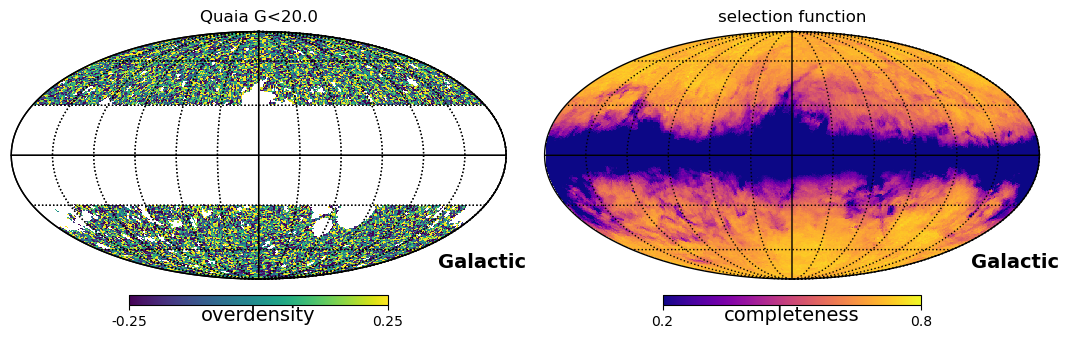

In [33]:
# plot
fig = plt.figure(figsize=(16,3))
hp.mollview(overdensity_map_sf_quaia, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=f'Quaia G<{d.maglim}')
hp.graticule()
hp.mollview(selfunc_quaia, coord=['C','G'], min=0.2, max=0.8, badcolor='w', fig=fig, sub=(1,3,2), cmap='plasma',
            unit='completeness', title=f'selection function')
hp.graticule()

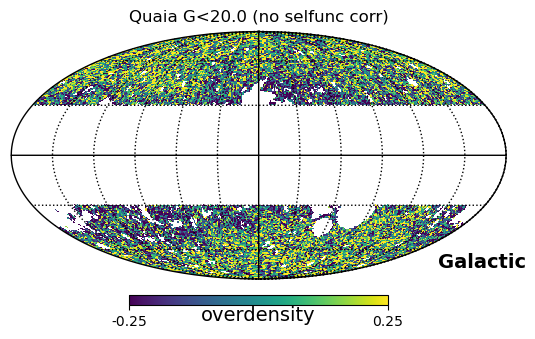

In [34]:
fig = plt.figure(figsize=(16,3))
hp.mollview(overdensity_map_quaia, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=f'Quaia G<{d.maglim} (no selfunc corr)')
hp.graticule()

### abby comparing overdensity maps

In [41]:
# compare catalogs to make sure this isn't the issue:
# d.initial_catfn is G20.5 since we're doing the mag cut!
cat_low = Table.read('/scratch/aew492/quasars/catalogs/quaia/quaia_G20.0.fits')

In [42]:
# pulling out abby's code to directly compare
lon, lat = cat_low['ra'], cat_low['dec'] # could triple check that the catalog is correct, but hopefully fine?!
pix_idx = hp.ang2pix(d.NSIDE, lon, lat, lonlat=True)
datamap = np.bincount(pix_idx, minlength=hp.nside2npix(d.NSIDE)).astype(float) # float!

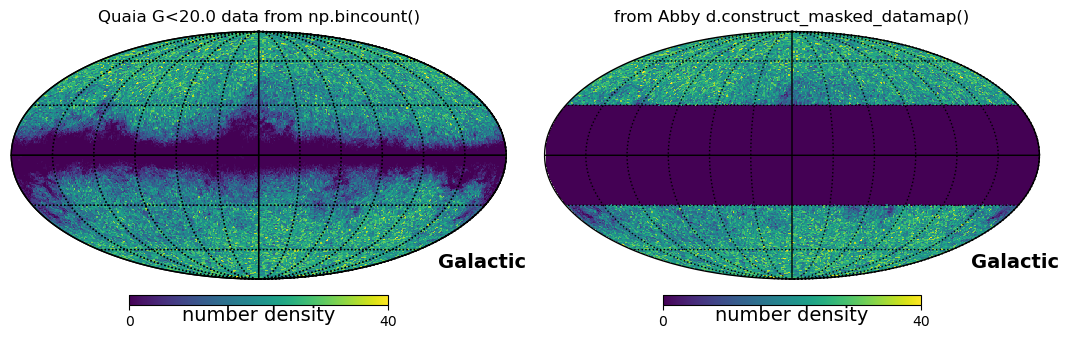

In [43]:
# compare the two data maps 
fig = plt.figure(figsize=(16,3))
hp.mollview(datamap, coord=['C','G'], min=0, max=40, badcolor='w', fig=fig, sub=(1,3,1),
            unit='number density', title=f'Quaia G<{d.maglim} data from np.bincount()')
hp.graticule()
hp.mollview(d.datamap, coord=['C','G'], min=0, max=40, badcolor='w', fig=fig, sub=(1,3,2),
            unit='number density', title=f'from Abby d.construct_masked_datamap()')
hp.graticule()

In [44]:
# are these the same aside from the galactic plane mask?
lon_, lat_ = hp.pix2ang(d.NSIDE, np.arange(d.NPIX), lonlat=True)
b = SkyCoord(lon_, lat_, frame='icrs', unit=u.deg).galactic.b
gal_plane_mask = (np.abs(b) >= d.blim*u.deg)
np.allclose(datamap[gal_plane_mask], d.datamap[gal_plane_mask])

True

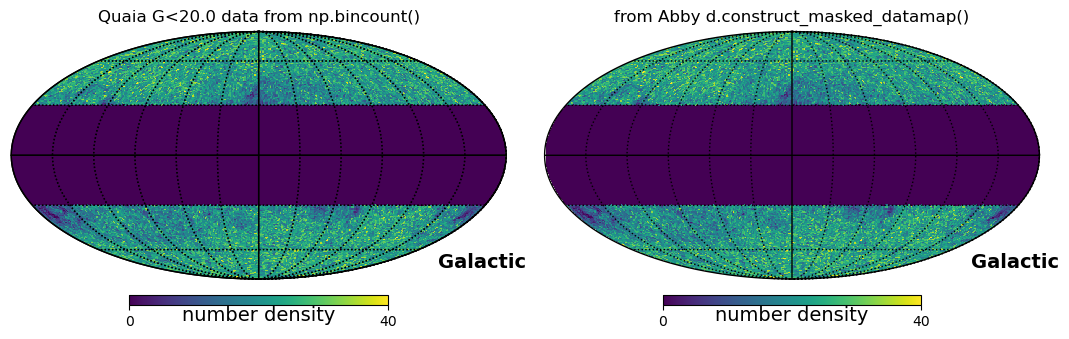

In [45]:
# compare the two data maps 
fig = plt.figure(figsize=(16,3))
datamap_ = datamap.copy()
datamap_[~gal_plane_mask] = 0.
hp.mollview(datamap_, coord=['C','G'], min=0, max=40, badcolor='w', fig=fig, sub=(1,3,1),
            unit='number density', title=f'Quaia G<{d.maglim} data from np.bincount()')
hp.graticule()
hp.mollview(d.datamap, coord=['C','G'], min=0, max=40, badcolor='w', fig=fig, sub=(1,3,2),
            unit='number density', title=f'from Abby d.construct_masked_datamap()')
hp.graticule()

/state/partition1/job-47692403/ipykernel_2477825/2843856176.py:1: RuntimeWarning: invalid value encountered in divide
  hp.mollview(d.datamap / datamap_, coord=['C','G'], min=0.99, max=1.01, badcolor='w',


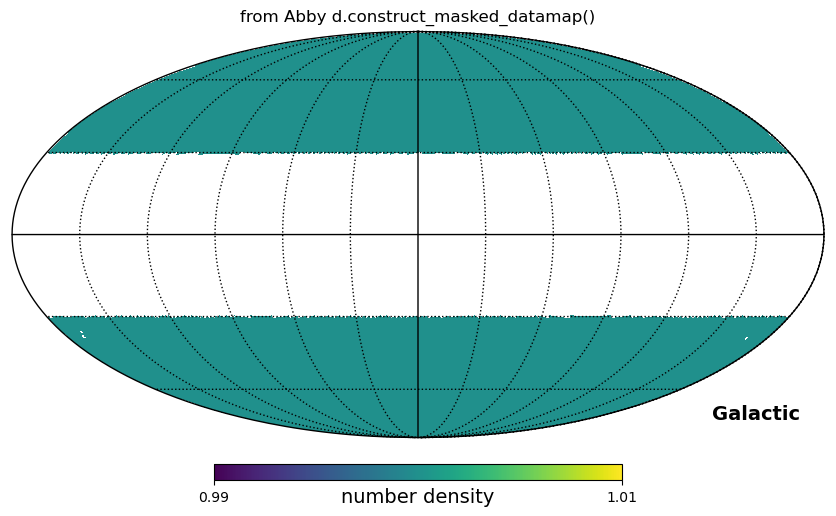

In [46]:
hp.mollview(d.datamap / datamap_, coord=['C','G'], min=0.99, max=1.01, badcolor='w',
            unit='number density', title=f'from Abby d.construct_masked_datamap()')
hp.graticule()

In [47]:
# mask the data map
masked_datamap_uncorr = np.multiply(datamap_, d.mask, where=(d.mask!=0), out=np.full(len(datamap), np.nan))

# correct by selection function
masked_datamap = masked_datamap_uncorr / selfunc_quaia

# overdensities
delta_abby = masked_datamap / np.nanmean(masked_datamap) - 1

In [48]:
np.allclose(overdensity_map_sf_quaia[d.mask], delta_abby[d.mask])

True

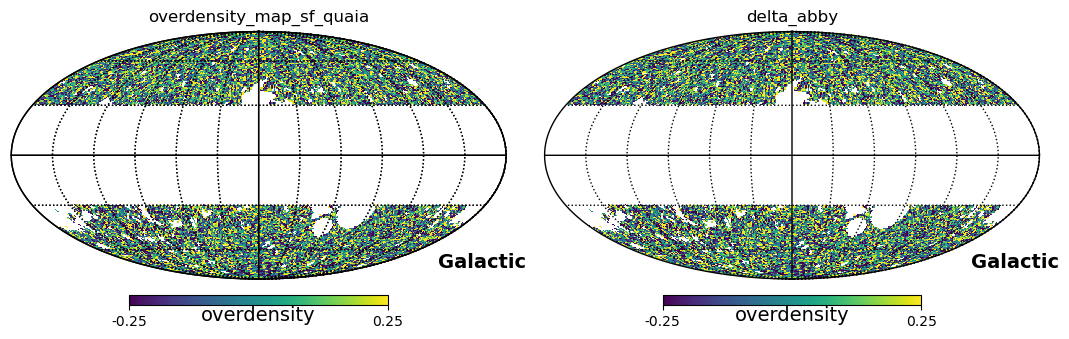

In [49]:
# plot
fig = plt.figure(figsize=(16,3))
hp.mollview(overdensity_map_sf_quaia, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=f'overdensity_map_sf_quaia')
hp.graticule()
hp.mollview(delta_abby, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,2),
            unit='overdensity', title=f'delta_abby')
hp.graticule()

# C_ells direct

In [95]:
# Quaia
ells, Cells_quaia = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_quaia,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=selfunc_quaia)

In [96]:
ells

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [97]:
save_dir = '../../quasar_data_abby/jackknife'
Cells_quaia_std = np.load(os.path.join(save_dir, f'jk_Cells_std_quaia_sfcorr_ellmax{max_ell}.npy'),
                            allow_pickle=True).item()['Cells_std']

In [98]:
noise_dir = '../../quasar_data_abby/noise_Cells'
res_quaia = np.load(f'{noise_dir}/quaia/noise_Cells_fullsky_ellmax1_100trials.npy', allow_pickle=True).item()
noise_quaia_Cell = res_quaia['Cells_fullsky'][0]

In [99]:
expected_C1_quaia = C_1(expected_dipamp_quaia)

# NaMaster

Following Alonso+2023 approach, https://github.com/damonge/quaia-cosmo-s8/blob/main/notebooks/CellCalculator.ipynb !

Define bins etc

In [18]:
# Bins
#b = nmt.NmtBin(d.NSIDE, nlb=30)
l_max = max_ell
ells_nmt = np.arange(1, l_max+1)
bpws = np.arange(len(ells_nmt))
weights = np.ones(len(ells_nmt))/len(ells_nmt)
b = nmt.NmtBin(d.NSIDE, ells=ells_nmt, bpws=bpws, weights=weights)
#b = nmt.NmtBin(d.NSIDE, nlb=1, lmax=3)

leff = b.get_effective_ells()
print(leff)

NameError: name 'nmt' is not defined

In [19]:
print(np.sum(selfunc_quaia>0), len(selfunc_quaia))
print(np.sum(~np.isnan(overdensity_map_sf_quaia)))
print(np.sum(d.mask>0))

42407 49152
22165
22165


In [59]:
map_quaia = overdensity_map_sf_quaia.copy()
map_quaia[np.isnan(map_quaia)] = 0

In [54]:
# careful, this is not d.initial_catfn bc we're doing the mag cut!
cat = cat_low #Table.read('../../quasar_data_abby/catalogs/quaia/quaia_G20.0.fits')

# NOTE alonso paper mask did:
#  mask_b = sel > sel_threshold
#  mask = sel.copy()
#  mask[~mask_b] = 0.0

# actually this min completeness is already included in the mask! in abbys code
mask_b = d.mask & (selfunc_quaia > min_completeness)
print(np.allclose(mask_b, d.mask))
mask = selfunc_quaia.copy()
mask[~mask_b] = 0.0

# Get angular mask and cut catalog
ipix = hp.ang2pix(d.NSIDE, cat['ra'], cat['dec'], lonlat=True)
maskflag = mask_b[ipix]
ipix = ipix[maskflag]

# Calculate overdensity field
NPIX = hp.nside2npix(d.NSIDE)
nmap = np.bincount(ipix, minlength=NPIX)
nmean = np.sum(nmap*mask_b)/np.sum(mask*mask_b)
delta = np.zeros(NPIX)
delta[mask_b] = nmap[mask_b]/(nmean*mask[mask_b])-1

# Calculate coupled noise power spectrum
# eqn 4.12 in Alonso+2023 https://arxiv.org/pdf/2306.17748
nmean_srad = nmean * NPIX / (4*np.pi)
nl_coupled = np.mean(mask) / nmean_srad * np.ones((1, 3*d.NSIDE))

print(nmean, NPIX, nmean_srad)
print(nl_coupled.shape, nl_coupled[0,:5])

True
33.63223392439692 49152 131548.84672612033
(1, 192) [2.25758224e-06 2.25758224e-06 2.25758224e-06 2.25758224e-06
 2.25758224e-06]


Get the selfunc-weighted mean the way that's intuitive to me

In [55]:
nmean_ksf = np.sum(nmap[mask_b]/(mask[mask_b]))/np.sum(mask_b)
delta_ksf = np.zeros(NPIX)
delta_ksf[mask_b] = nmap[mask_b]/(nmean_ksf*mask[mask_b])-1

nmean_srad_ksf = nmean_ksf * NPIX / (4*np.pi)
nl_coupled_ksf = np.mean(mask) / nmean_srad_ksf * np.ones((1, 3*d.NSIDE))
print("David mean:", nmean, "ksf mean:", nmean_ksf)

David mean: 33.63223392439692 ksf mean: 33.63190694514303


They agree to the 0.001's place!

Now let's try recreating abby's

In [56]:
# pulling out abby's code to directly compare
lon, lat = cat_low['ra'], cat_low['dec'] # could triple check that the catalog is correct, but hopefully fine?!
pix_idx = hp.ang2pix(d.NSIDE, lon, lat, lonlat=True)

# not doing this from alonso: 
# maskflag = mask_b[ipix]
# ipix = ipix[maskflag]

datamap = np.bincount(pix_idx, minlength=hp.nside2npix(d.NSIDE))
# Changed the out array bc it was keeping the datamap type which was ints, 
# so all nans became 2^63
masked_datamap_uncorr = np.multiply(datamap, d.mask, where=(d.mask!=0), 
                                    #out=np.full_like(datamap, np.nan))
                                    out=np.full(len(datamap), np.nan))

# nmap should be same as masked_datamap_uncorr in unmasked region; 
# we are just masking at pixels after, rather than sources in masked pixels first. 
assert np.allclose(nmap[mask_b], masked_datamap_uncorr[mask_b])

# now we can get delta
masked_datamap = masked_datamap_uncorr / selfunc_quaia
delta_abby = masked_datamap / np.nanmean(masked_datamap) - 1

/state/partition1/job-47692403/ipykernel_2477825/2329181495.py:12: RuntimeWarning: invalid value encountered in multiply
  masked_datamap_uncorr = np.multiply(datamap, d.mask, where=(d.mask!=0),


In [57]:
np.allclose(mask_b, d.mask)

True

In [60]:
print("Is abby's way the same as using ksf's mean?", np.allclose(delta_abby[mask_b], delta_ksf[mask_b]))
print("Does my recreation of abby's method agree with the output of QSOSample function?", \
      np.allclose(delta_abby[mask_b], map_quaia[mask_b]))

Is abby's way the same as using ksf's mean? True
Does my recreation of abby's method agree with the output of QSOSample function? True


Great about the first! But confused about the second :/

Looking at some individual values to understand scale of diffs

In [160]:
ii = 4200
delta[ii:ii+10], delta_abby[ii:ii+10], delta_ksf[ii:ii+10], map_quaia[ii:ii+10]

(array([-0.11188653,  0.36616404, -0.18327596, -0.37438711,  0.15737   ,
         0.04990898, -0.12273872, -0.1264462 ,  0.11475661,  0.14127912]),
 array([-0.11187789,  0.36617733, -0.18326802, -0.37438102,  0.15738126,
         0.04991919, -0.12273019, -0.12643771,  0.11476745,  0.14129022]),
 array([-0.11187789,  0.36617733, -0.18326802, -0.37438102,  0.15738126,
         0.04991919, -0.12273019, -0.12643771,  0.11476745,  0.14129022]),
 array([-0.10919966,  0.37029719, -0.18080508, -0.3724944 ,  0.16087147,
         0.05308534, -0.12008468, -0.12380338,  0.11812916,  0.14473191]))

In [170]:
np.mean(delta[mask_b]), np.mean(delta_abby[mask_b]), np.mean(delta_ksf[mask_b]), np.mean(map_quaia[mask_b])

(-9.722198490382863e-06,
 -1.053071458142084e-16,
 1.0747099127614419e-16,
 1.7134450361550803e-16)

In [171]:
np.std(delta[mask_b]), np.std(delta_abby[mask_b]), np.std(delta_ksf[mask_b]), np.std(map_quaia[mask_b])

(0.2186319271985916,
 0.21863405280224965,
 0.2186340528022497,
 0.22131501927853428)

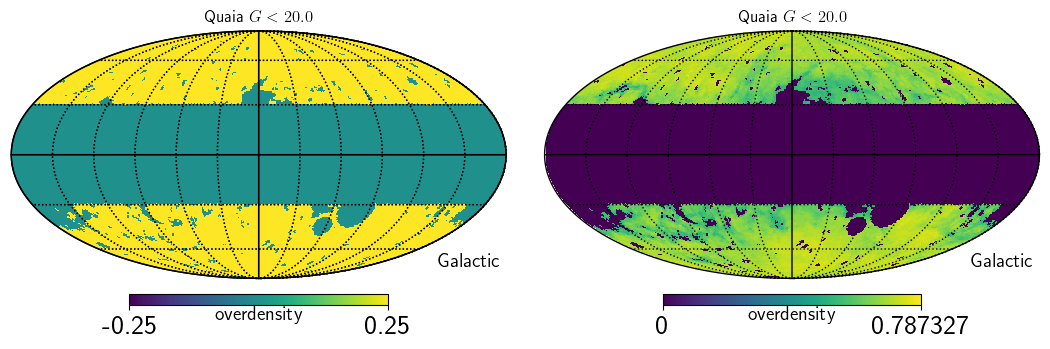

In [115]:
fig = plt.figure(figsize=(16,3))
hp.mollview(mask_b, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=rf'Quaia $G<{d.maglim}$')
hp.graticule()
hp.mollview(mask, coord=['C','G'], min=0, max=np.max(mask), badcolor='w', fig=fig, sub=(1,3,2),
            unit='overdensity', title=rf'Quaia $G<{d.maglim}$')
hp.graticule()

/tmp/ipykernel_24153/2081258374.py:7: RuntimeWarning: invalid value encountered in divide
  hp.mollview(nmap/mask, coord=['C','G'],


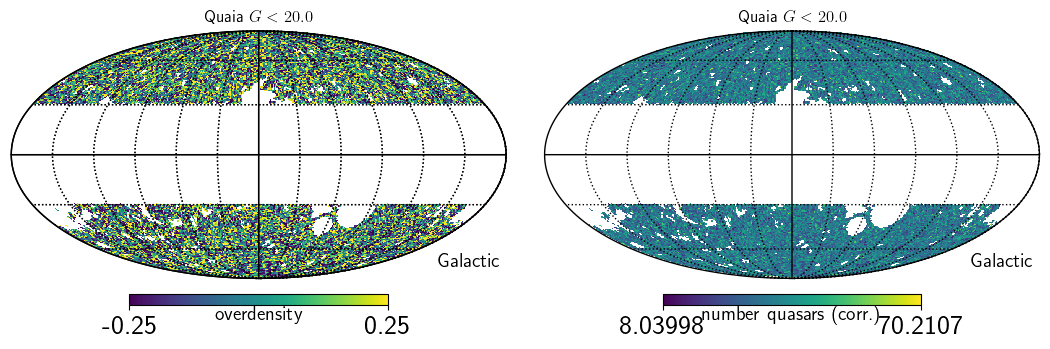

In [116]:
fig = plt.figure(figsize=(16,3))
map_masked = delta*mask_b
map_masked[map_masked==0] = hp.UNSEEN
hp.mollview(map_masked, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=rf'Quaia $G<{d.maglim}$')
hp.graticule()
hp.mollview(nmap/mask, coord=['C','G'], 
            #min=-0.25, max=0.25, 
            badcolor='w', fig=fig, sub=(1,3,2),
            unit='number quasars (corr.)', title=rf'Quaia $G<{d.maglim}$')
hp.graticule()

Delta and map_quaia should both have been corrected by the selfunc

In [117]:
f_quaia = nmt.NmtField(mask, [map_quaia], n_iter=0)

In [118]:
f_cat = nmt.NmtField(mask, [delta], n_iter=0)

In [172]:
f_ksf = nmt.NmtField(mask, [delta_ksf], n_iter=0)

Set up C_ell calculator and compute

In [174]:
# Calculator
def get_cl(f1, f2, b, pnl=None):
    pcl = nmt.compute_coupled_cell(f1, f2)
    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f1, f2, b)
    cl = w.decouple_cell(pcl)
    if pnl is not None:
        nl = w.decouple_cell(pnl)
        cl -= nl
    else:
        nl = np.zeros_like(cl)
    wins = w.get_bandpower_windows()
    return cl, nl, w, wins.squeeze()

In [175]:
cl, nl, w, Bbl = get_cl(f_quaia, f_quaia, b, pnl=nl_coupled)
#cl, nl, w, Bbl = get_cl(f_quaia, f_quaia, pnl=None)
print(cl)

[[ 2.04164948e-04  6.27421620e-05 -3.77812861e-05 -5.65920329e-06
   5.82151651e-05  4.72650636e-05  1.75059848e-05  6.98670263e-06]]


In [176]:
cl_full = nmt.compute_full_master(f_quaia, f_quaia, b)
print(cl_full)

[[ 2.16606538e-04  7.70500242e-05 -2.46899952e-05  7.06160155e-06
   6.96710175e-05  5.88045400e-05  3.48462773e-05  2.42827354e-05]]


In [177]:
cl_cat, nl_cat, w_cat, Bbl_cat = get_cl(f_cat, f_cat, b, pnl=nl_coupled)
#cl, nl, w, Bbl = get_cl(f_quaia, f_quaia, pnl=None)
print(cl_cat)

[[ 2.03323890e-04 -1.10604188e-06 -2.98631463e-05 -4.68296600e-06
   4.90963804e-05  2.50781243e-05  2.37132187e-05  1.32635348e-05]]


In [178]:
cl_ksf, nl_ksf, w_ksf, Bbl_ksf = get_cl(f_ksf, f_ksf, b, pnl=nl_coupled_ksf)
#cl, nl, w, Bbl = get_cl(f_quaia, f_quaia, pnl=None)
print(cl_ksf)

[[ 2.03353959e-04 -1.00668542e-06 -2.98651439e-05 -4.72641429e-06
   4.90964174e-05  2.50866902e-05  2.37162147e-05  1.32582190e-05]]


Covs

In [179]:
cws = {}

def get_cov(f1, f2, f3, f4, w12, w34):
    fs = [f1, f2, f3, f4]
    ms = [f.get_mask() for f in fs]
    # Compute all pseudo-Cls
    cls = np.array([[nmt.compute_coupled_cell(fs[i], fs[j])/np.mean(ms[i]*ms[j])
                     for i in range(4)] for j in range(4)])
    cw = nmt.NmtCovarianceWorkspace()
    cw.compute_coupling_coefficients(f1, f2, f3, f4)
    cv = nmt.gaussian_covariance(cw, 0, 0, 0, 0, cls[0, 2], cls[0, 3], cls[1, 2], cls[1, 3], w12, wb=w34)
    return cv

In [180]:
f = f_quaia
cv = get_cov(f, f, f, f, w, w)

In [181]:
cv.shape

(8, 8)

In [182]:
np.sqrt(np.diag(cv))

array([2.17057296e-04, 6.29794889e-05, 4.66049432e-05, 2.68810818e-05,
       4.20582679e-05, 3.40498928e-05, 2.28924562e-05, 1.63389789e-05])

In [183]:
Cells_quaia_std[1:]

array([3.91612631e-05, 2.92938432e-05, 1.25074157e-05, 1.82484418e-05,
       2.33241365e-05, 1.98003192e-05, 1.40538246e-05, 1.48740955e-05])

Plottt

[1 2 3 4 5 6 7 8] [8.58177244e-05 5.64874681e-05 2.26747850e-05 2.65196767e-05
 4.50546225e-05 4.90199242e-05 2.47962997e-05 3.14288070e-05]


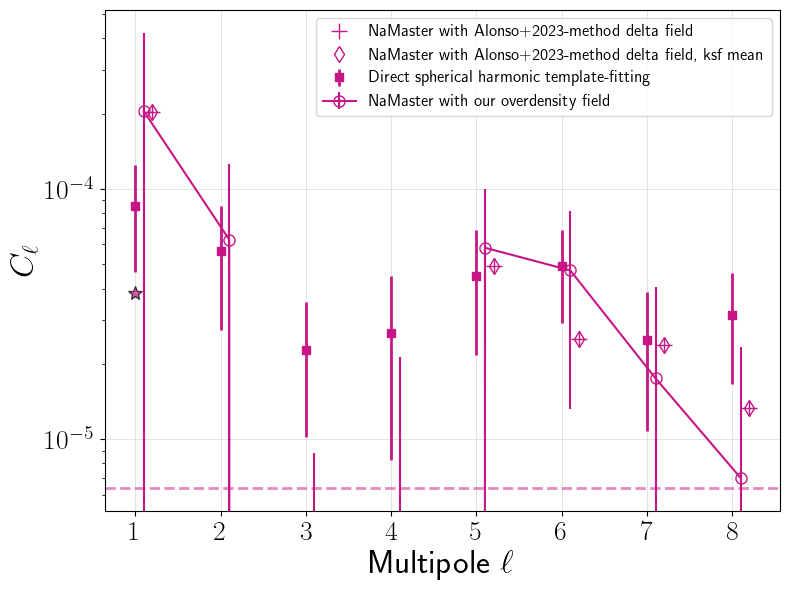

In [185]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
#kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)
kwargs = dict(ls='None', ms=6, alpha=1, lw=lw)


# ax.plot(leff+0.1, cl_full[0], color=color_quaia, marker='o', markersize=8, markerfacecolor='None',
#         ls='None', label='Quaia / namaster')

print(ells[1:], Cells_quaia[1:])
ax.errorbar(ells[1:], Cells_quaia[1:], yerr=Cells_quaia_std[1:],
            c=color_quaia, label=r'Direct spherical harmonic template-fitting', marker='s', **kwargs)

# ax.plot(leff+0.1, cl[0], color=color_quaia, marker='o', markersize=8, markerfacecolor='None',
#         ls='None', label='NaMaster with our overdensity field')
ax.errorbar(leff+0.1, cl[0], yerr=np.sqrt(np.diag(cv)),
            color=color_quaia, marker='o', markersize=8, markerfacecolor='None',
            #ls='None', 
            label='NaMaster with our overdensity field')


ax.plot(leff+0.2, cl_cat[0], color=color_quaia, marker='+', markersize=12, #markerfacecolor='None',
        ls='None', lw=2, label='NaMaster with Alonso+2023-method delta field')

ax.plot(leff+0.2, cl_ksf[0], color=color_quaia, marker='d', markersize=8, markerfacecolor='None',
        ls='None', lw=2, label='NaMaster with Alonso+2023-method delta field, ksf mean')


# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
#ax.axhline(noise_quaia_cross, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
#ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
#ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
#ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
#ax.legend(loc=1, handles=handles)
ax.legend(loc=1, fontsize=12)

TODO 
- use verbose=True in abby's functions
- understand delta vs overdensity map, looking at abby's code

# Dependence on lmax

In [ ]:
l_max_arr = np.arange(1, max_ell+1)
cl_arr_lmaxdep = []
cl_nonl_arr_lmaxdep = []
leff_arr_lmaxdep = []
for l_max in l_max_arr:

    # Bins
    ells_nmt = np.arange(1, l_max+1)
    bpws = np.arange(len(ells_nmt))
    weights = np.ones(len(ells_nmt))/len(ells_nmt)
    b = nmt.NmtBin(d.NSIDE, ells=ells_nmt, bpws=bpws, weights=weights)
    leff = b.get_effective_ells()
    
    cl, nl, w, Bbl = get_cl(f_quaia, f_quaia, b, pnl=nl_coupled)
    
    cl_nonl, nl_nonl, w_nonl, Bbl_nonl = get_cl(f_quaia, f_quaia, b, pnl=None)
    
    cl_arr_lmaxdep.append(cl)
    cl_nonl_arr_lmaxdep.append(cl_nonl)
    leff_arr_lmaxdep.append(leff)

In [ ]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
#kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)
kwargs = dict(ls='None', ms=6, alpha=1, lw=lw)

ax.errorbar(ells[1:], Cells_quaia[1:], yerr=Cells_quaia_std[1:],
                c=color_quaia, label='Quaia direct',
                marker='s', **kwargs)

for i in range(len(l_max_arr)):

    ax.errorbar(leff_arr_lmaxdep[i]+0.1, cl_arr_lmaxdep[i][0], #yerr=np.sqrt(np.diag(cv)),
                color=color_quaia, marker='o', markersize=8, markerfacecolor='None',
                #ls='None', 
                label=rf'Namaster, $lmax={l_max_arr[i]}$',
                alpha=l_max_arr[i]/10)

#     ax.plot(leff+0.2, cl_cat[0], color=color_quaia, marker='+', markersize=12, #markerfacecolor='None',
#             ls='None', lw=2, label='NaMaster with Alonso+2023-method delta field')


# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
#ax.axhline(noise_quaia_cross, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
#ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
#ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
#ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
#ax.legend(loc=1, handles=handles)
ax.legend(loc='upper right', fontsize=10)

Very little dependence on l_max! Only notable one is l=4 which sometimes goes negative and sometimes is just small.

In [ ]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
fig.suptitle('No NL correction')
#kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)
kwargs = dict(ls='None', ms=6, alpha=1, lw=lw)

ax.errorbar(ells[1:], Cells_quaia[1:], yerr=Cells_quaia_std[1:],
                c=color_quaia, label='Quaia direct',
                marker='s', **kwargs)

for i in range(len(l_max_arr)):

    ax.errorbar(leff_arr_lmaxdep[i]+0.1, cl_nonl_arr_lmaxdep[i][0], #yerr=np.sqrt(np.diag(cv)),
                color=color_quaia, marker='o', markersize=8, markerfacecolor='None',
                #ls='None', 
                label=rf'Namaster, $lmax={l_max_arr[i]}$',
                alpha=l_max_arr[i]/10)

#     ax.plot(leff+0.2, cl_cat[0], color=color_quaia, marker='+', markersize=12, #markerfacecolor='None',
#             ls='None', lw=2, label='NaMaster with Alonso+2023-method delta field')


# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
#ax.axhline(noise_quaia_cross, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
#ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
#ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
#ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
#ax.legend(loc=1, handles=handles)
ax.legend(loc='upper right', fontsize=10)

If we don't correct for the NL term, we see more differences, but still not too much (not nearly as much as in direct fitting case).